In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df = pd.read_csv('data/Electric_Production.csv')
print(df.shape)

(397, 2)


In [3]:
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [4]:
df.rename(columns={'IPG2211A2N':'Production'},inplace = True)

In [5]:
df.head()

,DATE,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [6]:
df.set_index('DATE',inplace = True)

<AxesSubplot:xlabel='DATE'>

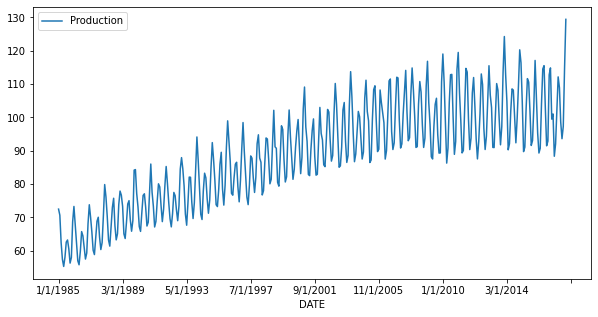

In [7]:
df.plot(figsize = (10,5))

In [8]:
df.index = pd.to_datetime(df.index)

In [9]:
df.index.year.unique()

Int64Index([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
            1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
            2018],
           dtype='int64', name='DATE')

In [10]:
df['year'] = df.index.year
df['month'] = df.index.month

In [11]:
sns.set(rc={'figure.figsize':(11, 4)})

<AxesSubplot:xlabel='DATE'>

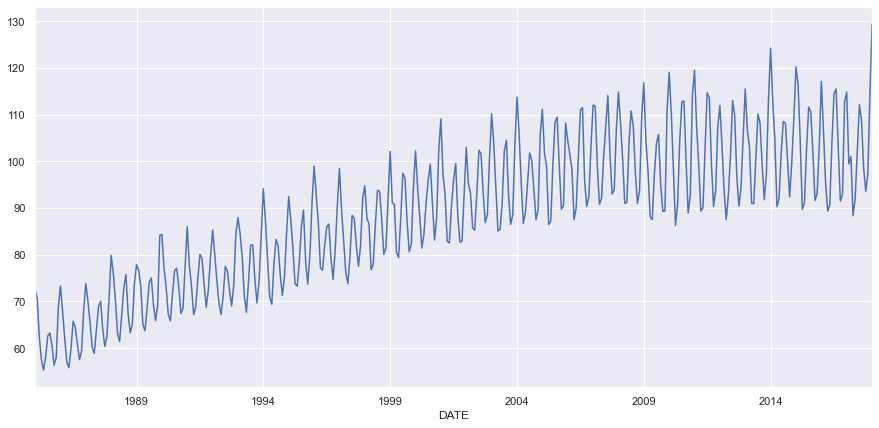

In [12]:
df['Production'].plot(figsize = (15,7))

From the above plot we can clearly see seasonality and trend, we'll be using SARIMAX

Text(0, 0.5, 'Production')

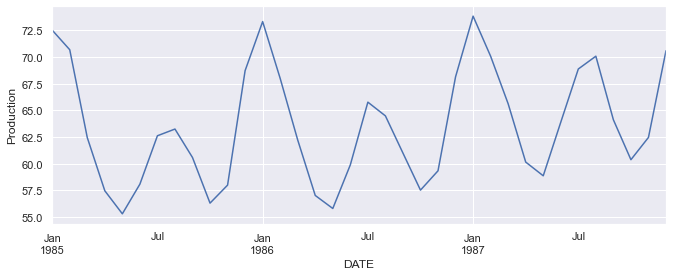

In [13]:
ax = df.loc['1985':'1987','Production'].plot()
ax.set_ylabel('Production')

<AxesSubplot:xlabel='DATE'>

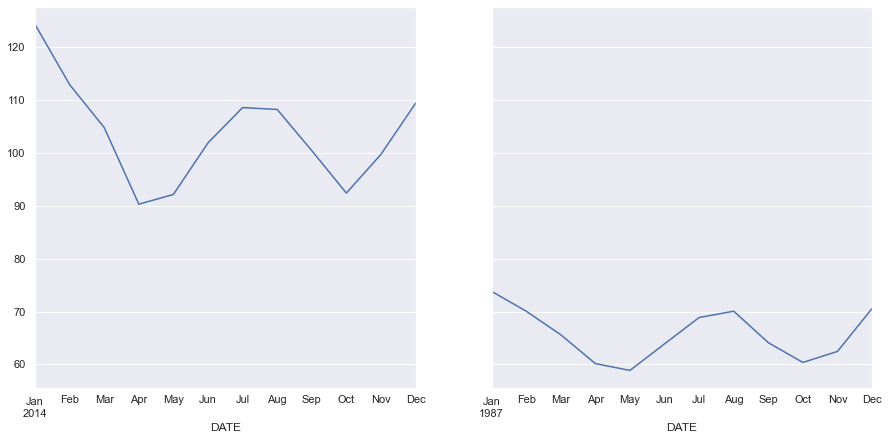

In [14]:
fig, axes = plt.subplots(1,2, figsize = (15,7),sharey= True)
df.loc['2014','Production'].plot(ax = axes[0])
df.loc['1987','Production'].plot(ax = axes[1])

We could see a similar pattern over the months of the year(seasonality), and trend as well

In [15]:
train_series = df.loc[:'2013','Production']
test_series = df.loc['2014':'2017','Production']

In [16]:
print(len(train_series))
print(len(test_series))

348
48


In [17]:
train_df = train_series.to_frame(name='train')
test_df = test_series.to_frame('test')

<AxesSubplot:xlabel='DATE'>

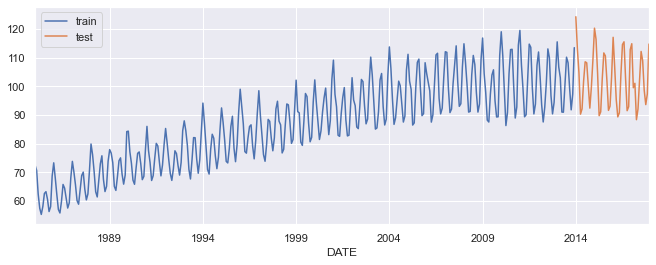

In [18]:
train_df.join(test_df,how='outer').plot()

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df.rename(columns = {'train':'Production'},inplace = True)
train_df['Production'] = scaler.fit_transform(train_df)
train_df.head(10)

,Production
DATE,
1985-01-01,0.267872
1985-02-01,0.239305
1985-03-01,0.111186
1985-04-01,0.033601
1985-05-01,0.000000
1985-06-01,0.043247
1985-07-01,0.113835
1985-08-01,0.123625
1985-09-01,0.082114


In [20]:
test_df.rename(columns = {'test':'Production'},inplace = True)
test_df['Production'] = scaler.transform(test_df)
test_df.head()

,Production
DATE,
2014-01-01,1.074282
2014-02-01,0.897045
2014-03-01,0.770543
2014-04-01,0.544959
2014-05-01,0.573745


In [21]:
order = (4, 1, 0)
#since it's a monthly data we'll use 12 as d 's' parameter in the seasonal_order parameter(found that in the stats model docs) 
#since data isn't stationary we use differencing parameter of atleast 1
seasonal_order = (1, 1, 0, 12)
model = SARIMAX(endog=train_df, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                         Production   No. Observations:                  348
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 598.655
Date:                            Sun, 23 Jan 2022   AIC                          -1185.310
Time:                                    01:34:16   BIC                          -1162.425
Sample:                                01-01-1985   HQIC                         -1176.187
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2821      0.051     -5.576      0.000      -0.381      -0.183
ar.L2         -0.3673      0.055   

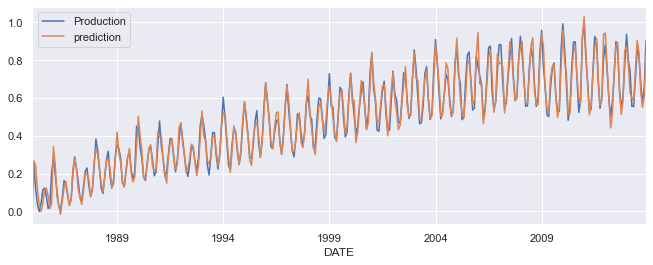

In [22]:
train_df['prediction'] = results.predict()
train_df['Production'].plot()
train_df['prediction'].plot()
plt.legend()

doing a pretty good job training, let's predict for the test set now

In [23]:
from datetime import date
test_df['prediction'] = results.predict(start = date(2014,1,1), end = date(2017,12,1))

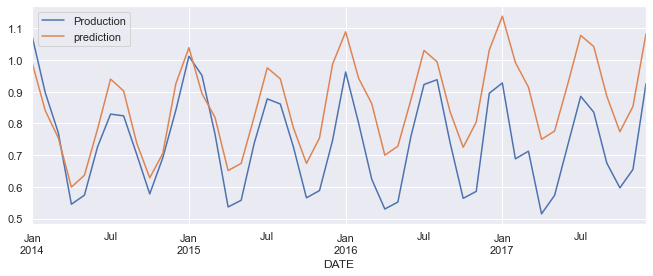

In [24]:
test_df['Production'].plot()
test_df['prediction'].plot()
plt.legend()

In [25]:
#evaluate model's perfoemance using root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_df['Production'], test_df['prediction']))
print(rmse)

0.145899914228715


Not a bad one